<h1 align="left">Pavement Friction: Distinguish the Effects of Multiple Treatments</h1>

<img src="https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Attribution.png" width="400">


Transportation agencies would like to know whether its multiple treatment on the pavement sections are successful in increasing pavement friction. In other words, they would like to learn the **treatment effect** of each treatment on the section's skid resistance: particularly the **heterogeneous treatment effect**. 

In an ideal world, transporation agency would run experiments where each senerio would receive a random assortment of treatments. However, this approach can be logistically prohibitive or strategically unsound: the transportation agency might not have the resources to design such experiments or they might not want to risk transportation accidents by randomizing their incentives to road users.

In this notebook, we show how tools from the [Causica](https://github.com/microsoft/causica), library can use historical treatment data to learn the effects of multiple treatments.

For this exercise, we use the observational data summarized from Oklahoma's transportation administration.

In the next section, we introduce the data. We then discover the causal graph, the relationship between each variable in the simulated data. With this generated graph, we use estimate the personalized treatment effects for each pavement section. 

## Environment Setup
It might be necessary to install `graphviz` and `pygraphviz` for improved visualisations of the graphs.

For Ubuntu with poetry, run
```
sudo apt-get install graphviz libgraphviz-dev
```

In [1]:
import os
from operator import itemgetter
import warnings

import fsspec
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch

from pytorch_lightning.callbacks import TQDMProgressBar
from tensordict import TensorDict

from causica.datasets.causica_dataset_format import CAUSICA_DATASETS_PATH, Variable
from causica.distributions import ContinuousNoiseDist
from causica.lightning.data_modules.basic_data_module import BasicDECIDataModule
from causica.lightning.modules.deci_module import DECIModule
from causica.sem.sem_distribution import SEMDistributionModule
from causica.sem.structural_equation_model import ite
from causica.training.auglag import AugLagLRConfig

warnings.filterwarnings("ignore")
test_run = bool(os.environ.get("TEST_RUN", False))  # used by testing to run the notebook as a script

# Data

The dataset contains 331 records of pavement friction under different treatments. 
**Question 1: Would the data not enough for causal ML using Causica?** 

We create one outcome of interest:

Feature Name | Type | Details 
:--- |:--- |:--- 
**Friction** | continuous | \$ Average Friction measured on the pavement section

We consider six possible treatments, the interventions whose impact we wish to measure:
**Question 2: Is it reasonable transfer the nominal variable to six binary columns?**

Feature Name | Type | Details 
:--- |:--- |:--- 
**AC TypeS4** | binary | whether the pavement section received AC TypeS4 during the year
**AC TypeS5** | binary | whether the pavement section received AC TypeS5 during the year
**AC TypeS6** | binary | whether the pavement section received AC TypeS6 during the year
**Diamond Grinding** | binary | whether the pavement section received Diamond Grinding during the year
**Thin Overlay** | binary | whether the pavement section received Thin Overlay during the year
**UTBWC** | binary | whether the pavement section received UTBWC during the year


Finally, we consider a variety of additional characteristics that may affect pavement friction. Including these types of features is crucial for causal analysis in order to map the full causal graph and separate the true effects of treatments on outcomes from other correlation generated by other influences. 
**Question 3: Is it right way to keep replace the category variable to 0, 1, 2, 3?**
Feature Name | Type | Details 
:--- |:--- |:--- 
**Binder Type** | Category | 3 types of asphalt binder used in the pavement section
**Aggregates** | Category | 10 types of aggregates used in the pavement section
**Aggregate Type** | Category | 4 aggregates stone types
**LA Abrevasion** | Continuous | one feature of aggregates
**Micro Deval** | Continuous | another feature of aggregates
**AADT** | Numerial/Continuous | Traffic volume
**Year after Treatment** | Numerial/Continuous | measurement date after the treatment



#### Import the Data

In [2]:
root_path = os.path.abspath('')
data_path = os.path.join(root_path, 'Friction_Treatments.xlsx')
data_path

'c:\\github\\causica\\examples\\Friction_Treatments.xlsx'

In [3]:
df_import = pd.read_excel(data_path, sheet_name='Sheet1')
df_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Friction_value        331 non-null    float64
 1   Year_after_treatment  331 non-null    int64  
 2   Treatment_type        331 non-null    object 
 3   Binder                331 non-null    object 
 4   Aggregate01           331 non-null    object 
 5   Type                  331 non-null    object 
 6   LA_Abrasion           331 non-null    float64
 7   Micro_Deval           331 non-null    float64
 8   AADT                  331 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 23.4+ KB


#### Data Preprocessing
seperate the treatment into several binary columns

In [4]:
df = pd.get_dummies(df_import, columns=['Treatment_type'], prefix_sep='', prefix='')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Friction_value        331 non-null    float64
 1   Year_after_treatment  331 non-null    int64  
 2   Binder                331 non-null    object 
 3   Aggregate01           331 non-null    object 
 4   Type                  331 non-null    object 
 5   LA_Abrasion           331 non-null    float64
 6   Micro_Deval           331 non-null    float64
 7   AADT                  331 non-null    float64
 8   AC TypeS4             331 non-null    uint8  
 9   AC TypeS5             331 non-null    uint8  
 10  AC TypeS6             331 non-null    uint8  
 11  Diamond Griding       331 non-null    uint8  
 12  Thin Overlay          331 non-null    uint8  
 13  UTBWC                 331 non-null    uint8  
dtypes: float64(4), int64(1), object(3), uint8(6)
memory usage: 22.8+ KB
None


 replace the category variable Binder, Aggregate01, Type to numbers

In [5]:
mapping = {' PG 64-22 OK': 1, ' PG 70-28 OK': 2, ' PG 76-28 OK': 3,
           'APAC-Central #014 (Jenny Lind, AR)': 1, 'APAC-Central #018 (Spiro, OK)': 2, 'APAC-Central #066 (Pawhuska, OK)': 3,
              'Dolese Co (Davis, OK)': 4, 'Dolese Co (Hartshorne, OK)': 5, 'Dolese Co. (Richards Spur, OK)': 6,
                'Hanson Aggregates, WRP Inc (Davis, OK)': 7, 'Martin-Marietta (Mill Creek, OK)': 8, 'Martin-Marietta (Sawyer, OK)': 9,
                'Martin-Marietta (Snyder, OK)': 10,
              'Granite': 1, 'Limestone': 2, 'Rhyolite': 3, 'Sandstone': 4
           }
df.replace({'Binder': mapping, 'Aggregate01': mapping, 'Type': mapping}, inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Friction_value        331 non-null    float64
 1   Year_after_treatment  331 non-null    int64  
 2   Binder                331 non-null    int64  
 3   Aggregate01           331 non-null    int64  
 4   Type                  331 non-null    int64  
 5   LA_Abrasion           331 non-null    float64
 6   Micro_Deval           331 non-null    float64
 7   AADT                  331 non-null    float64
 8   AC TypeS4             331 non-null    uint8  
 9   AC TypeS5             331 non-null    uint8  
 10  AC TypeS6             331 non-null    uint8  
 11  Diamond Griding       331 non-null    uint8  
 12  Thin Overlay          331 non-null    uint8  
 13  UTBWC                 331 non-null    uint8  
dtypes: float64(4), int64(4), uint8(6)
memory usage: 22.8 KB


,Friction_value,Year_after_treatment,Binder,Aggregate01,Type,LA_Abrasion,Micro_Deval,AADT,AC TypeS4,AC TypeS5,AC TypeS6,Diamond Griding,Thin Overlay,UTBWC
0,38.900000,0,3,7,3,12.0,8.2,36553.125,1,0,0,0,0,0
1,37.666667,2,3,7,3,12.0,8.2,36553.125,1,0,0,0,0,0
2,37.500000,3,3,7,3,12.0,8.2,36553.125,1,0,0,0,0,0
3,37.070000,0,3,7,3,12.0,8.2,36500.000,1,0,0,0,0,0
4,33.730000,2,3,7,3,12.0,8.2,36500.000,1,0,0,0,0,0


In [6]:
df['Year_after_treatment'] = df['Year_after_treatment'].astype(float)
df['Binder'] = df['Binder'].astype(float)
df['Aggregate01'] = df['Aggregate01'].astype(float)
df['Type'] = df['Type'].astype(float)
df['AC TypeS4'] = df['AC TypeS4'].astype(int)
df['AC TypeS5'] = df['AC TypeS5'].astype(int)
df['AC TypeS6'] = df['AC TypeS6'].astype(int)
df['Diamond Griding'] = df['Diamond Griding'].astype(int)
df['Thin Overlay'] = df['Thin Overlay'].astype(int)
df['UTBWC'] = df['UTBWC'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Friction_value        331 non-null    float64
 1   Year_after_treatment  331 non-null    float64
 2   Binder                331 non-null    float64
 3   Aggregate01           331 non-null    float64
 4   Type                  331 non-null    float64
 5   LA_Abrasion           331 non-null    float64
 6   Micro_Deval           331 non-null    float64
 7   AADT                  331 non-null    float64
 8   AC TypeS4             331 non-null    int32  
 9   AC TypeS5             331 non-null    int32  
 10  AC TypeS6             331 non-null    int32  
 11  Diamond Griding       331 non-null    int32  
 12  Thin Overlay          331 non-null    int32  
 13  UTBWC                 331 non-null    int32  
dtypes: float64(8), int32(6)
memory usage: 28.6 KB


In [7]:
# Load metadata telling us the data type of each column
variables_path = os.path.join(root_path, 'Friction_Treatments_Variable.json')
with fsspec.open(variables_path, mode="r", encoding="utf-8") as f:
    variables_spec = json.load(f)["variables"]
variables_spec

[{'name': 'Friction_value',
  'type': 'continuous',
  'group_name': 'Friction_value'},
 {'name': 'Year_after_treatment',
  'type': 'continuous',
  'group_name': 'Year_after_treatment'},
 {'name': 'Binder', 'type': 'continuous', 'group_name': 'Binder'},
 {'name': 'Aggregate01', 'type': 'continuous', 'group_name': 'Aggregate01'},
 {'name': 'Type', 'type': 'continuous', 'group_name': 'Type'},
 {'name': 'LA_Abrasion', 'type': 'continuous', 'group_name': 'LA_Abrasion'},
 {'name': 'Micro_Deval', 'type': 'continuous', 'group_name': 'Micro_Deval'},
 {'name': 'AADT', 'type': 'continuous', 'group_name': 'AADT'},
 {'name': 'AC TypeS4', 'type': 'binary', 'group_name': 'AC TypeS4'},
 {'name': 'AC TypeS5', 'type': 'binary', 'group_name': 'AC TypeS5'},
 {'name': 'AC TypeS6', 'type': 'binary', 'group_name': 'AC TypeS6'},
 {'name': 'Diamond Griding',
  'type': 'binary',
  'group_name': 'Diamond Griding'},
 {'name': 'Thin Overlay', 'type': 'binary', 'group_name': 'Thin Overlay'},
 {'name': 'UTBWC', 'typ

In [8]:
data_module = BasicDECIDataModule(
    df.loc[:, "Friction_value":"UTBWC"],  # remove ground truth from dataframe
    variables=[Variable.from_dict(d) for d in variables_spec],
    batch_size=100,
    normalize=True,
)
num_nodes = len(data_module.dataset_train.keys())

In [9]:
# Data Sample
print("Data Shape:", df.shape)
df.head()

Data Shape: (331, 14)


,Friction_value,Year_after_treatment,Binder,Aggregate01,Type,LA_Abrasion,Micro_Deval,AADT,AC TypeS4,AC TypeS5,AC TypeS6,Diamond Griding,Thin Overlay,UTBWC
0,38.900000,0.0,3.0,7.0,3.0,12.0,8.2,36553.125,1,0,0,0,0,0
1,37.666667,2.0,3.0,7.0,3.0,12.0,8.2,36553.125,1,0,0,0,0,0
2,37.500000,3.0,3.0,7.0,3.0,12.0,8.2,36553.125,1,0,0,0,0,0
3,37.070000,0.0,3.0,7.0,3.0,12.0,8.2,36500.000,1,0,0,0,0,0
4,33.730000,2.0,3.0,7.0,3.0,12.0,8.2,36500.000,1,0,0,0,0,0


In [10]:
# Import the Ground Truth Causal Effects

# Unlike most real-world causal use cases, in this case we know the true causal relationships between treatments
# and outcome because we have simulated the data.

# We also extract those effects, created during data generation, to check our later causal effect estimates.
# For now, we calculate the ground truth average and individual treatment effects (ATEs and ITEs).

In [11]:
# outcome = "Revenue"
# treatment_columns = ["Tech Support", "Discount", "New Engagement Strategy"]

# # extract ground truth effects
# ground_truth_effects = df.loc[:, "Direct Treatment Effect: Tech Support":]

# ground_truth_ites = {
#     treatment: ground_truth_effects[f"Total Treatment Effect: {treatment}"] for treatment in treatment_columns
# }

# ground_truth_ates = {key: val.mean(axis=0) for key, val in ground_truth_ites.items()}

In [12]:
# adjacency_path = root_path + "/true_graph_gml_string.txt"
# with fsspec.open(adjacency_path, mode="r", encoding="utf-8") as f:
#     true_adj = nx.parse_gml(f.read())

# fig, axis = plt.subplots(1, 1, figsize=(8, 8))
# labels = {node: i for i, node in enumerate(true_adj.nodes)}

# try:
#     layout = nx.nx_agraph.graphviz_layout(true_adj, prog="dot")
# except (ModuleNotFoundError, ImportError):
#     layout = nx.layout.spring_layout(true_adj)

# for node, i in labels.items():
#     axis.scatter(layout[node][0], layout[node][1], label=f"{i}: {node}")
# axis.legend()
# nx.draw_networkx(true_adj, pos=layout, with_labels=True, arrows=True, labels=labels, ax=axis)

# Discover the Causal Graph

### [Optional] Adding domain-specific graph constraints
To improve the quality of the learned graph, it is possible to place constraints on the graph that DECI learns. The constraints come in two flavours:
 - *negative constraints* mean a certain edge cannot exist in the graph,
 - *positive constraints* mean a certain edge must exist in the graph.

In [13]:
outcome = "Friction_value"
treatment_columns = ["AC TypeS4", "AC TypeS5", "AC TypeS6", "Diamond Griding", "Thin Overlay", "UTBWC"]

In [14]:
# The constraint matrix has the same shape as the adjacency matrix
# A `nan` value means no constraint
# A 0 value means a negative constraint
# A 1 value means a positive constraint
node_name_to_idx = {key: i for i, key in enumerate(data_module.dataset_train.keys())}
node_name_to_idx

{'Friction_value': 0,
 'Year_after_treatment': 1,
 'Binder': 2,
 'Aggregate01': 3,
 'Type': 4,
 'LA_Abrasion': 5,
 'Micro_Deval': 6,
 'AADT': 7,
 'AC TypeS4': 8,
 'AC TypeS5': 9,
 'AC TypeS6': 10,
 'Diamond Griding': 11,
 'Thin Overlay': 12,
 'UTBWC': 13}

In [32]:
constraint_matrix = np.full((num_nodes, num_nodes), np.nan, dtype=np.float32)

First, we say that certain basic attributes of companies cannot be changed by other variables (at least on the time scale we are considering). The attributes we constraint to have no parents are: Year_after_treatment, Several Treatments, AADT.

In [33]:
non_child_nodes = [
    "Year_after_treatment",
    "AADT",
    "AC TypeS4",
    "AC TypeS5",
    "AC TypeS6",
    "Diamond Griding",
    "Thin Overlay",
    "UTBWC"
]
non_child_idxs = itemgetter(*non_child_nodes)(node_name_to_idx)
constraint_matrix[:, non_child_idxs] = 0.0

Second, we introduce the constraint that Year_after_treatment & AADT & Friction cannot be the cause of any other node.

In [34]:
friction_idx = node_name_to_idx["Friction_value"]
year_idx = node_name_to_idx["Year_after_treatment"]
AADT_idx = node_name_to_idx["AADT"]

constraint_matrix[friction_idx, :] = 0.0
constraint_matrix[year_idx, :] = 0.0
constraint_matrix[AADT_idx, :] = 0.0

constraint_matrix[year_idx, friction_idx] = 1.0
constraint_matrix[AADT_idx, friction_idx] = 1.0


Third, we introduce the constraint that the binder and aggregates properties cannot be interracted. 

In [35]:
Binder_idx = node_name_to_idx["Binder"]
Aggr_idx = node_name_to_idx["Aggregate01"]
Type_idx = node_name_to_idx["Type"]
LA_idx = node_name_to_idx["LA_Abrasion"]
MD_idx = node_name_to_idx["Micro_Deval"]

constraint_matrix[Binder_idx, Aggr_idx] = 0.0
constraint_matrix[Binder_idx, Type_idx] = 0.0
constraint_matrix[Binder_idx, MD_idx] = 0.0
constraint_matrix[Binder_idx, LA_idx] = 0.0

constraint_matrix[Aggr_idx, Binder_idx] = 0.0
constraint_matrix[Type_idx, Binder_idx] = 0.0
constraint_matrix[MD_idx, Binder_idx] = 0.0
constraint_matrix[LA_idx, Binder_idx] = 0.0

constraint_matrix[Aggr_idx, Type_idx] = 1.0
constraint_matrix[Type_idx, Aggr_idx] = 1.0
constraint_matrix[MD_idx, Aggr_idx] = 0.0
constraint_matrix[LA_idx, Aggr_idx] = 0.0
# constraint_matrix[revenue_idx, planning_summit_idx] = np.nan

Finally, we make a constraint that says that different engagements do not directly cause one another. For example, giving Tech Support to a company is not a valid reason to give / not give them a Discount.

In [36]:
engagement_nodes = ["AC TypeS4", "AC TypeS5", "AC TypeS6", "Diamond Griding", "Thin Overlay", "UTBWC"]
engagement_idxs = itemgetter(*engagement_nodes)(node_name_to_idx)
for i in engagement_idxs:
    constraint_matrix[engagement_idxs, i] = 0.0

### Creating and training DECI model

The following snippets step through the process of:
 - configuring and creating a DECI model
 - training a model with graph constraints

#### DECI configuration

The DECI model has a number of hyperparameters, but attention need not be paid to all of them. Here we highlight key hyperparameters that might be changed to improve performance:
 - `noise_dist` is the type of DECI model that is trained with. It should be either Gaussian or Spline. Use a Spline for highly non-Gaussian data, or to fit a better density model of the observational data.
 
Other hyperparameters are less frequently changed.

In [37]:
pl.seed_everything(seed=1)  # set the random seed

lightning_module = DECIModule(
    noise_dist=ContinuousNoiseDist.GAUSSIAN,
    prior_sparsity_lambda=1.0,
    init_rho=1.0,
    init_alpha=0.0,
    auglag_config=AugLagLRConfig(lr_init_dict={"vardist": 1e-2, "icgnn": 3e-4, "noise_dist": 3e-3}),
)

lightning_module.constraint_matrix = torch.tensor(constraint_matrix)

trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=1000,
    fast_dev_run=test_run,
    callbacks=[TQDMProgressBar(refresh_rate=19)],
    enable_checkpointing=False,
)

Global seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
trainer.fit(lightning_module, datamodule=data_module)


  | Name        | Type                  | Params
------------------------------------------------------
0 | sem_module  | SEMDistributionModule | 20.1 K
1 | auglag_loss | AugLagLossCalculator  | 0     
------------------------------------------------------
19.9 K    Trainable params
196       Non-trainable params
20.1 K    Total params
0.081     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s] 

Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 41.36it/s, loss=2.9, v_num=16]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 35.92it/s, loss=2.9, v_num=16]


### Saving and Loading a DECI model

In [39]:
torch.save(lightning_module.sem_module, "deci_friction.pt")

In [40]:
sem_module: SEMDistributionModule = torch.load("deci_friction.pt")

# create a structural equation model using the most likely graph
sem = sem_module().mode

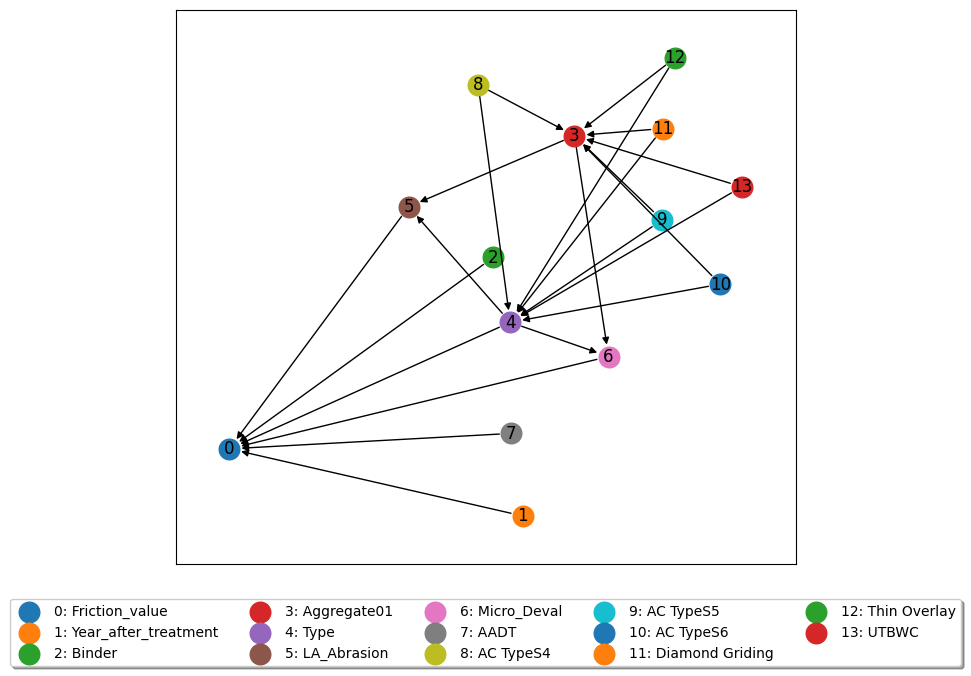

In [77]:
adjacency_path = os.path.join(root_path, 'labels.txt')
with fsspec.open(adjacency_path, mode="r", encoding="utf-8") as f:
    true_adj = nx.parse_gml(f.read())

fig, axis = plt.subplots(1, 1, figsize=(8, 8))
labels = {node: i for i, node in enumerate(true_adj.nodes)}

try:
    layout = nx.nx_agraph.graphviz_layout(true_adj, prog="dot")
except (ModuleNotFoundError, ImportError):
    layout = nx.layout.spring_layout(true_adj)

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
for node, i in labels.items():
    ax.scatter(layout[node][0], layout[node][1], label=f"{i}: {node}", s=220)
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

# for node, i in labels.items():
#     axis.scatter(layout[node][0], layout[node][1], label=f"{i}: {node}")
# axis.legend()
nx.draw_networkx(true_adj, pos=layout, with_labels=True, arrows=True, labels=labels, ax=axis, node_color="None")

In [78]:
graph = nx.from_numpy_array(sem.graph.cpu().numpy(), create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, dict(enumerate(data_module.dataset_train.keys())))
graph


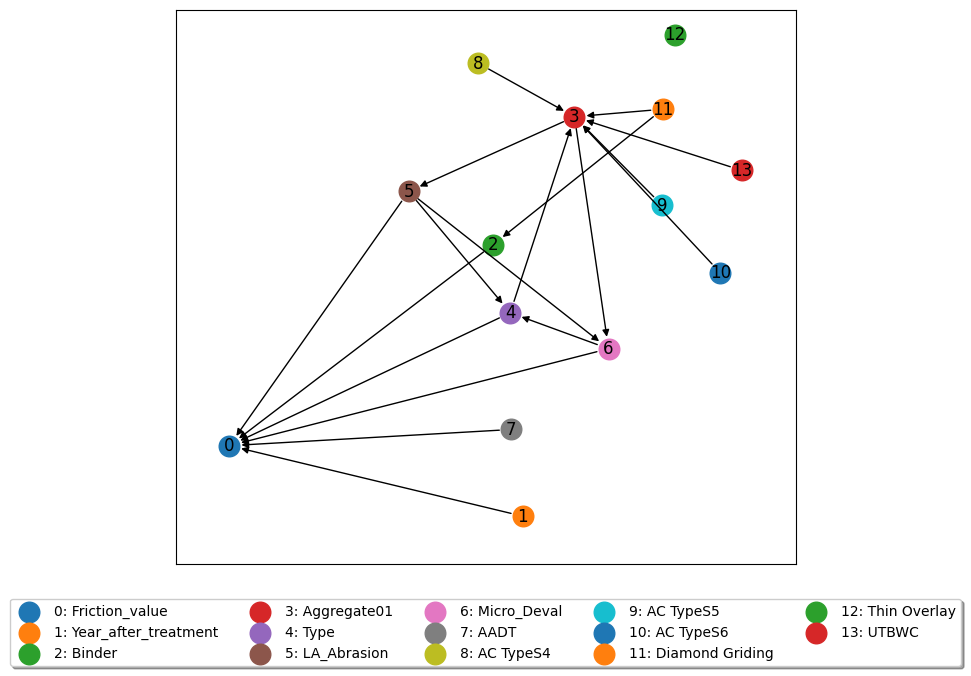

In [79]:
fig, axis = plt.subplots(1, 1, figsize=(8, 8))
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
for node, i in labels.items():
    ax.scatter(layout[node][0], layout[node][1], label=f"{i}: {node}", s=220)
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

nx.draw_networkx(graph, pos=layout, with_labels=True, arrows=True, labels=labels, ax=ax, node_color='none')

### Concluding graph discovery
The DECI model from Causica offers us a way to discover a causal graph from observational data. The learned graph can be iteratively refined by adding new graph constraints and retraining DECI to obtain a more realistic graph. 

# Treatment effect estimation

The causal graph identifies the likely paths of connection between features. This next step will quantify the strength of those relationships between treatment and outcomes. Our tools estimate both the average treatment effect across all customers (ATE) and how these treatment effects vary across customer features. If we are confident that we have included every feature that affects treatment intensity, we can also interpret these estimates as individual treatment effects (ITE), or the effect of treating a particular customer.

## Average Treatment Effect (ATE)
We can estimate the average treatment and estimate the error using samples from the intervened SEM

In [80]:
revenue_estimated_ate = {}
num_samples = 10 if test_run else 20000
sample_shape = torch.Size([num_samples])
transform = data_module.normalizer.transform_modules[outcome]().inv

for treatment in treatment_columns:
    intervention_a = TensorDict({treatment: torch.tensor([1.0])}, batch_size=tuple())
    intervention_b = TensorDict({treatment: torch.tensor([0.0])}, batch_size=tuple())

    rev_a_samples = transform(sem.do(interventions=intervention_a).sample(sample_shape)[outcome])
    rev_b_samples = transform(sem.do(interventions=intervention_b).sample(sample_shape)[outcome])

    ate_mean = rev_a_samples.mean(0) - rev_b_samples.mean(0)
    ate_std = np.sqrt((rev_a_samples.var(0) + rev_b_samples.var(0)) / num_samples)

    revenue_estimated_ate[treatment] = (
        ate_mean.cpu().numpy()[0],
        ate_std.cpu().numpy()[0],
    )
revenue_estimated_ate

{'AC TypeS4': (-0.038627625, 0.06543295),
 'AC TypeS5': (-0.016628265, 0.064705834),
 'AC TypeS6': (0.14192963, 0.064570814),
 'Diamond Griding': (0.6694565, 0.06676783),
 'Thin Overlay': (-0.06896973, 0.06526995),
 'UTBWC': (-0.08168411, 0.06589256)}

These graphs compare the average total treatment effects of Causica with the ground truth.

In [81]:
# fig, axes = plt.subplots(1, len(ground_truth_ates), figsize=(16, 4))
# fig.suptitle("Comparison of Ground Truth ATEs with DECI estimates")
# for ax, treatment in zip(axes, revenue_estimated_ate.keys()):
#     ax.errorbar([0], [revenue_estimated_ate[treatment][0]], [2 * revenue_estimated_ate[treatment][1]], fmt="o")
#     ax.scatter([0], [ground_truth_ates[treatment]], color="r", label="Ground Truth")
#     ax.legend()
#     ax.set_title(treatment)
#     ax.set_ylabel("Revenue difference ($)")

## Individual treatment effects (ITE)

Finally, Causica can estimate *individual* treatment effects: the difference between giving and not giving the engagement to a specific customer. Using the original data, we can examine what the difference in Revenue would be for each interaction if we had performed the intervention.

In [82]:
revenue_estimated_ite = {}

base_noise = sem.sample_to_noise(data_module.dataset_train)

for treatment in treatment_columns:
    do_sem = sem.do(interventions=TensorDict({treatment: torch.tensor([1.0])}, batch_size=tuple()))
    do_a_cfs = transform(do_sem.noise_to_sample(base_noise)[outcome]).cpu().detach().numpy()[:, 0]
    do_sem = sem.do(interventions=TensorDict({treatment: torch.tensor([0.0])}, batch_size=tuple()))
    do_b_cfs = transform(do_sem.noise_to_sample(base_noise)[outcome]).cpu().detach().numpy()[:, 0]
    revenue_estimated_ite[treatment] = do_a_cfs - do_b_cfs

revenue_estimated_ite

{'AC TypeS4': array([-1.31256104e-01, -1.03471375e+00,  5.91438293e-01, -1.32385254e-01,
        -1.04686546e+00,  6.07034683e-01,  4.48989868e-02, -7.05245972e-01,
         4.34894562e-02, -7.09095001e-01,  3.75585747e+00, -2.10649109e+00,
        -4.31519699e+00, -2.93242264e+00,  3.41626930e+00, -2.42476273e+00,
        -4.26185226e+00, -3.28062057e+00,  5.44468689e+00,  4.72799683e+00,
         1.50239944e+00,  4.20958710e+00,  3.34530258e+00, -1.08903503e+00,
        -4.58448410e-01,  1.12947273e+00, -8.10848236e-01, -4.12940979e-01,
         1.01458168e+00,  2.97592163e-01, -1.38882065e+00, -1.68701935e+00,
         2.97580719e-01, -1.38882065e+00, -1.68701935e+00, -1.20822906e-01,
         6.09931946e-02,  5.89027405e-01, -7.45010376e-03, -1.31610870e-01,
        -1.21269226e-02,  5.91362000e-01,  1.10862732e-01,  2.11936951e-01,
         3.07552338e-01,  2.44262695e-01,  2.63557434e-01,  2.12005615e-01,
         3.05519104e-01,  2.45552063e-01,  2.63759613e-01, -6.43737793e-01,

In [47]:
# fig, axes = plt.subplots(1, len(ground_truth_ates), figsize=(16, 4))
# fig.suptitle("Comparison of Ground Truth ITEs with DECI estimates")
# for ax, treatment in zip(axes, revenue_estimated_ite.keys()):
#     ax.scatter(revenue_estimated_ite[treatment], ground_truth_ites[treatment])
#     ax.set_title(treatment)
#     ax.set_xlabel("Estimated ITE ($)")
#     ax.set_ylabel("Ground Truth ITE ($)")